<a href="https://colab.research.google.com/github/Deolinda1506/ml/blob/main/notebook/glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Glaucoma Detection - Model Training and Evaluation 




In [ ]:
import sys
import os

# Add parent directory to path for imports
sys.path.append(os.path.abspath('..'))

import json
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import load_data_with_validation_split
from src.model import build_model, calculate_class_weights
from src.train_model import train_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

print("=" * 60)
print("GLAUCOMA DETECTION - MODEL TRAINING")
print("=" * 60)

2025-08-02 11:01:56.040953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 11:02:00.730279: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 11:02:02.574776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754132525.986356    2425 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754132526.762277    2425 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754132533.889491    2425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

SyntaxError: unterminated triple-quoted string literal (detected at line 124) (preprocessing.py, line 119)


1. DATA LOADING AND PREPROCESSING
Loading dataset...


Loading train:  16%|█▌        | 31/200 [00:00<00:01, 103.96it/s]

Loading train: 100%|██████████| 200/200 [00:01<00:00, 184.14it/s]


Successfully loaded 200 images from ../data/train


Loading test: 100%|██████████| 50/50 [00:00<00:00, 101.41it/s]


Successfully loaded 50 images from ../data/test
Training set: 200 images
Test set: 50 images
Image shape: (224, 224, 3)
Classes: [0 1]

Dataset Analysis:
{
  "total_images": 200,
  "class_distribution": {
    "glaucoma": 100,
    "normal": 100
  },
  "image_sizes": [
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
      512
    ],
    [
      512,
 

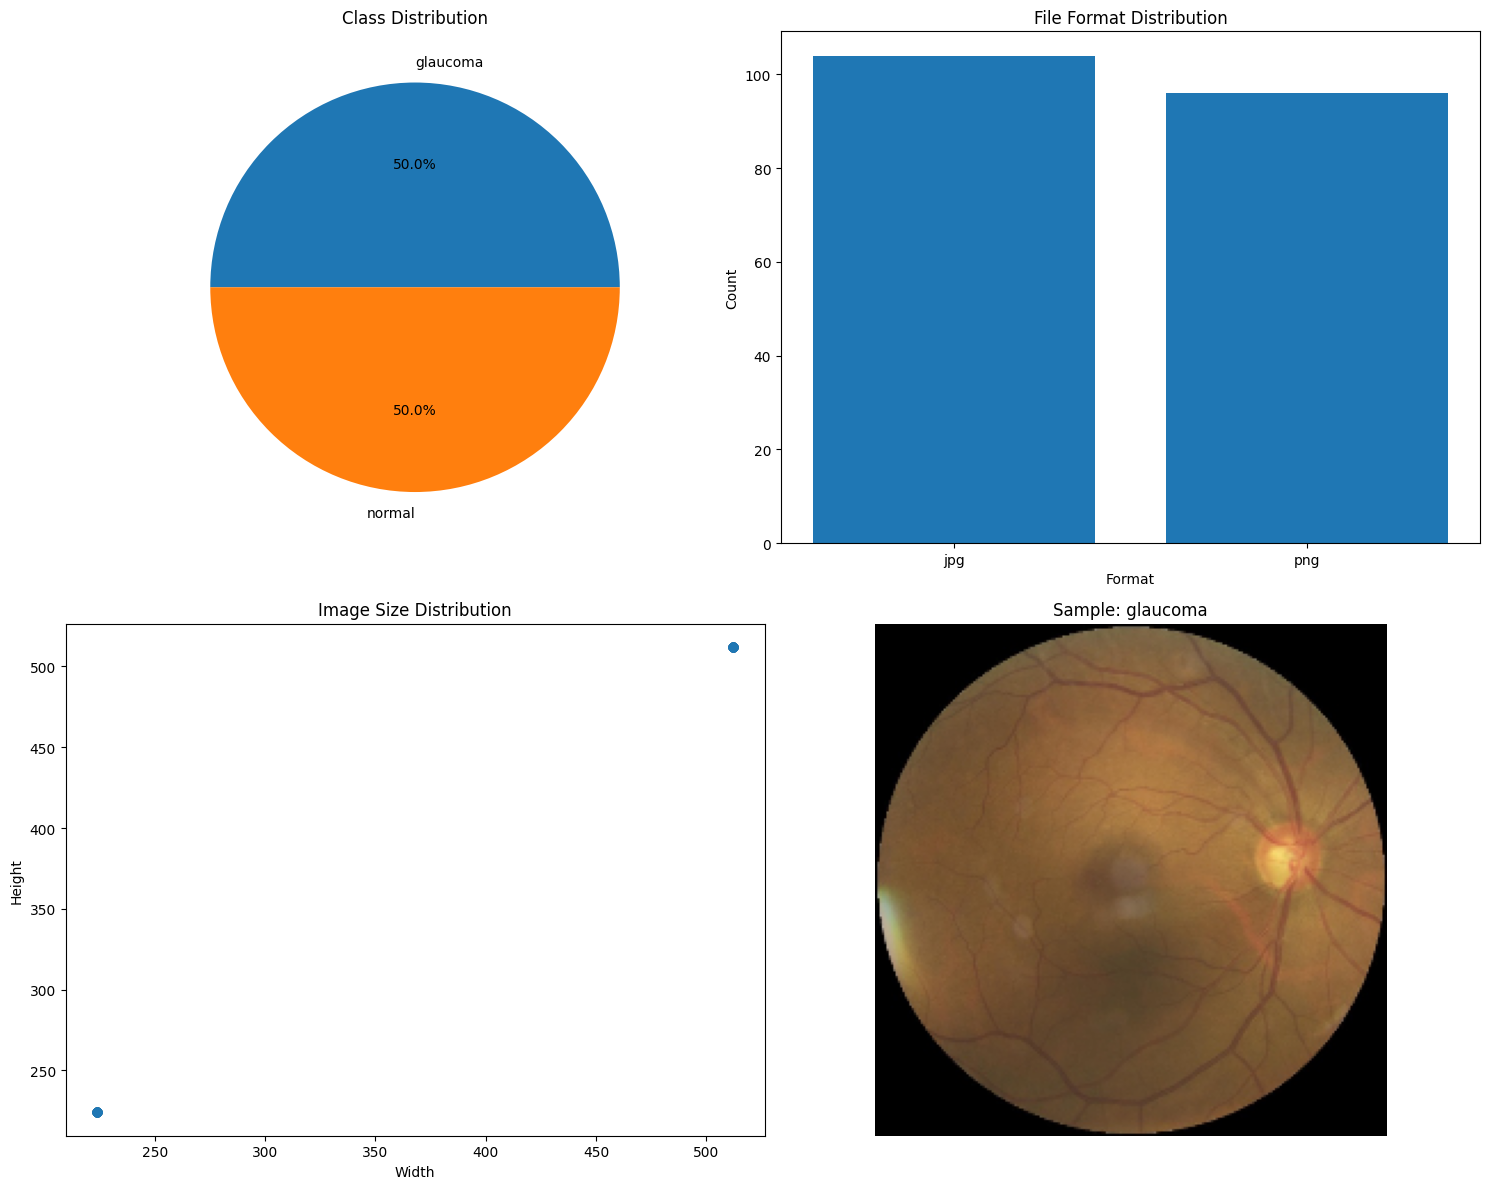


Data splits:
Training set: 160 images
Validation set: 40 images
Test set: 50 images


In [ ]:

# Model settings
IMAGE_SIZE = (224, 224)  # Standard size for medical imaging
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2   # 20% of training data for validation
EPOCHS = 20

# Output paths
MODEL_PATH = 'models/best_model.h5'
HISTORY_PATH = 'models/history.json'
STATIC_DIR = 'static'

print(f"Configuration:")
print(f"- Training data: {TRAIN_DIR}")
print(f"- Test data: {TEST_DIR}")
print(f"- Image size: {IMAGE_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Validation split: {VALIDATION_SPLIT}")
print(f"- Epochs: {EPOCHS}")


In [ ]:

print("\n" + "=" * 40)
print("STEP 1: LOADING DATA")
print("=" * 40)

# Load data with validation split
print("Loading data generators...")
train_gen, val_gen, test_gen, class_indices = load_data_with_validation_split(
    TRAIN_DIR, TEST_DIR, IMAGE_SIZE, BATCH_SIZE, VALIDATION_SPLIT
)

print(f"Found {train_gen.samples} training images")
print(f"Found {val_gen.samples} validation images") 
print(f"Found {test_gen.samples} test images")
print(f"Classes: {list(class_indices.keys())}")


2. MODEL ARCHITECTURE AND TRAINING
Model Architecture:


Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼───────────────────

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.5543 - loss: 0.6744 - precision: 0.5543 - recall: 0.5543 
Epoch 1: val_accuracy improved from None to 0.50000, saving model to ../models/glaucoma_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 130s 26s/step - accuracy: 0.5813 - loss: 0.6694 - precision: 0.5813 - recall: 0.5813 - val_accuracy: 0.5000 - val_loss: 0.6935 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.6814 - loss: 0.6281 - precision: 0.6814 - recall: 0.6814 
Epoch 2: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 127s 26s/step - accuracy: 0.7063 - loss: 0.6179 - precision: 0.7063 - recall: 0.7063 - val_accuracy: 0.5000 - val_loss: 0.7000 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7528 - loss: 0.5771 - precision: 0.7528 - recall: 0.7528 
Epoch 3: val_accuracy did not improve from 0.50000
5/5 ━━━━━━━━━━━━━━━━━━━━ 126s 26s/step - accuracy: 0.7875 - loss: 0.5567 - precision: 0.7875 - recall: 0.7875 - val_accuracy: 0.5000 - val_loss: 1.1147 - val_precision: 0.5000 - val_recall: 0.5000 - learnin


3. MODEL EVALUATION
Creating training history visualization...


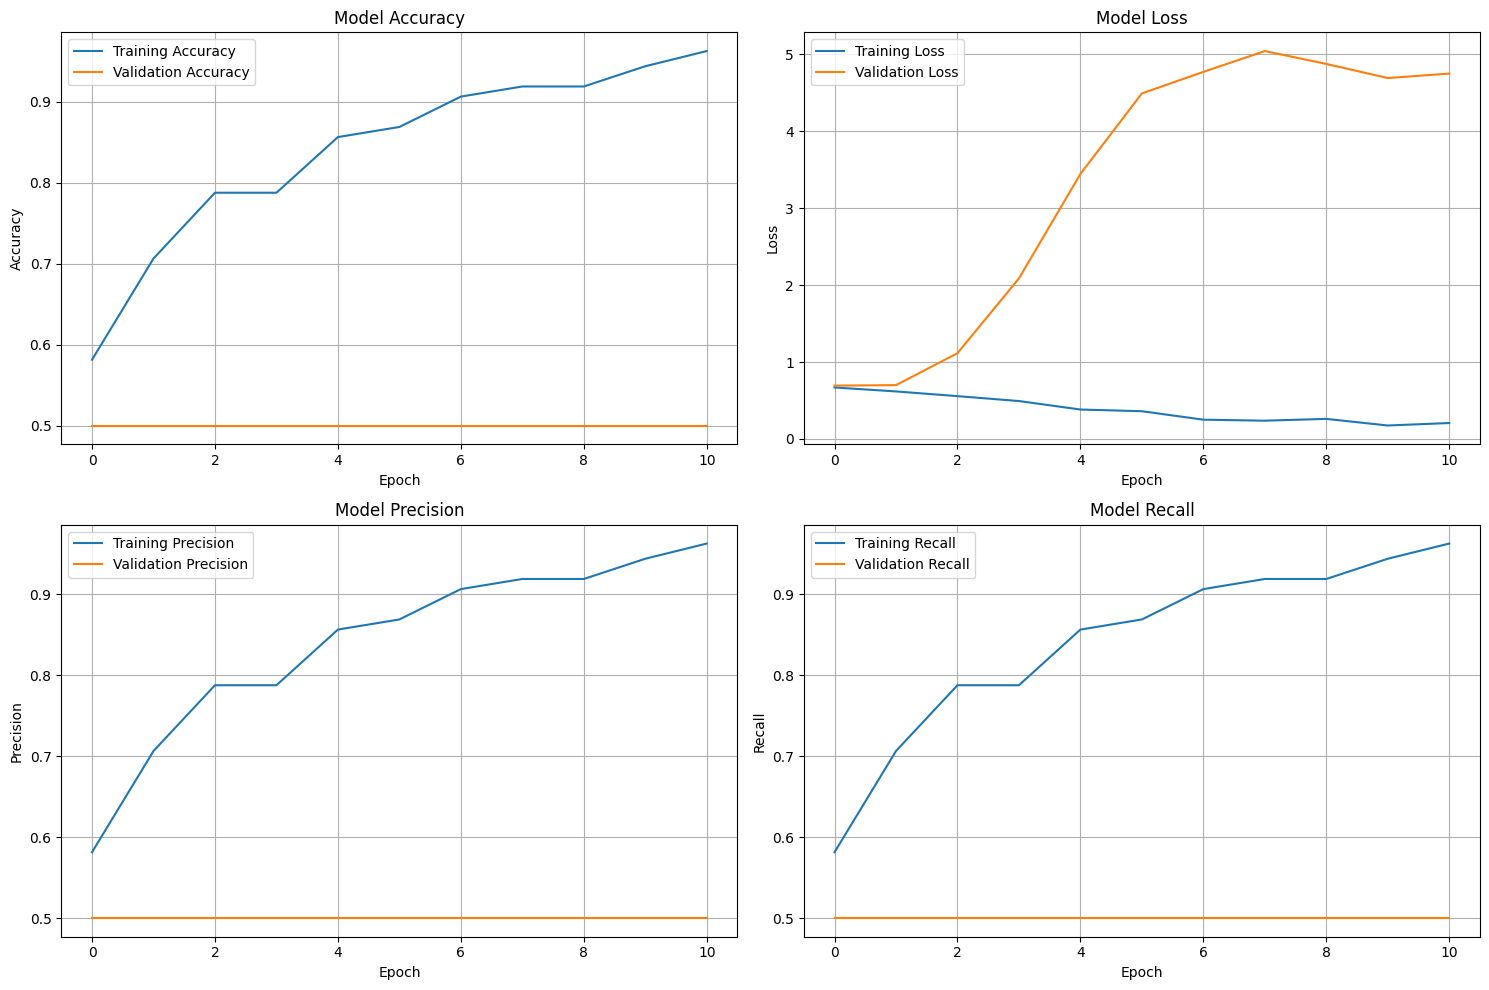


Evaluating model on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step

Test Set Metrics:
accuracy: 0.5000
precision: 0.5000
recall: 0.5000
f1_score: 0.5000
auc_score: 0.5328
loss: 0.6935
classification_report: {'Normal': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 25.0}, 'Glaucoma': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 25.0}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 50.0}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.33333333333333326, 'support': 50.0}}
confusion_matrix: [[25, 0], [25, 0]]
predictions: [[0.5138472318649292, 0.48615285754203796], [0.5138399600982666, 0.48615992069244385], [0.5138283371925354, 0.48617157340049744], [0.5138336420059204, 0.48616641759872437], [0.5138263702392578, 0.4861735701560974], [0.5138354301452637, 0.48616448044776917], [0.5138434171676636, 0.48615652322769165], [0.513853907585144, 0.48614609241485596], [0.5

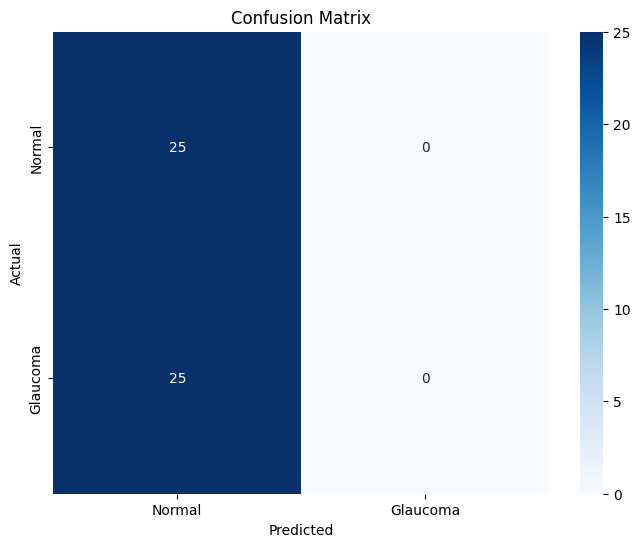


Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67        25
    Glaucoma       0.00      0.00      0.00        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50



In [ ]:
print("\n" + "=" * 40)
print("STEP 2: CALCULATING CLASS WEIGHTS")
print("=" * 40)

# Calculate class weights for imbalanced dataset
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(labels), 
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class weights calculated: {class_weight_dict}")

In [ ]:
print("\n" + "=" * 40)
print("STEP 3: VISUALIZING DATASET")
print("=" * 40)

# 1. Class Distribution Analysis
print("1. Analyzing class distribution...")
labels = list(class_indices.keys())
counts = [train_gen.labels.tolist().count(i) for i in range(len(labels))]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['lightblue', 'lightcoral'])
plt.title("Class Distribution in Training Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{STATIC_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Class distribution saved to static/class_distribution.png")

# 2. Sample Images Analysis
print("2. Analyzing sample images...")
x, y = next(train_gen)
plt.figure(figsize=(15, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i])
    plt.title(f"{labels[np.argmax(y[i])]}\nShape: {x[i].shape[:2]}")
    plt.axis('off')
plt.suptitle("Sample Training Images", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{STATIC_DIR}/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Sample images saved to static/sample_images.png")

# 3. Pixel Intensity Distribution Analysis
print("3. Analyzing pixel intensity distribution...")
sample_imgs, _ = next(train_gen)
all_pixels = sample_imgs.flatten()

plt.figure(figsize=(12, 5))

# Histogram of pixel values
plt.subplot(1, 2, 1)
plt.hist(all_pixels, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Pixel Intensity Distribution', fontweight='bold')
plt.xlabel('Pixel Value (0-1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Box plot of pixel statistics
plt.subplot(1, 2, 2)
pixel_stats = [np.mean(img) for img in sample_imgs]
plt.boxplot(pixel_stats, labels=['Mean Pixel Value'])
plt.title('Pixel Statistics per Image', fontweight='bold')
plt.ylabel('Mean Pixel Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{STATIC_DIR}/pixel_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Pixel analysis saved to static/pixel_analysis.png")

# 4. Image Size Analysis
print("4. Analyzing image characteristics...")
image_sizes = []
for class_name in labels:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_path):
        for img_file in os.listdir(class_path)[:10]:  # Sample 10 images per class
            img_path = os.path.join(class_path, img_file)
            try:
                from PIL import Image
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)
            except:
                continue

if image_sizes:
    widths, heights = zip(*image_sizes)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(widths, heights, alpha=0.6, color='green')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Image Dimensions Distribution', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist([w*h for w, h in image_sizes], bins=20, color='orange', alpha=0.7, edgecolor='black')
    plt.xlabel('Image Area (pixels²)')
    plt.ylabel('Frequency')
    plt.title('Image Area Distribution', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{STATIC_DIR}/image_characteristics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Image characteristics saved to static/image_characteristics.png")

# 5. Dataset Summary Statistics
print("5. Generating dataset summary...")
dataset_summary = {
    'total_images': len(train_gen.labels),
    'class_distribution': dict(zip(labels, counts)),
    'image_shape': x[0].shape,
    'pixel_range': (float(np.min(all_pixels)), float(np.max(all_pixels))),
    'mean_pixel_value': float(np.mean(all_pixels)),
    'std_pixel_value': float(np.std(all_pixels))
}

print("\n DATASET SUMMARY:")
print("=" * 40)
print(f"Total Images: {dataset_summary['total_images']}")
print(f"Image Shape: {dataset_summary['image_shape']}")
print(f"Pixel Range: {dataset_summary['pixel_range']}")
print(f"Mean Pixel Value: {dataset_summary['mean_pixel_value']:.4f}")
print(f"Pixel Standard Deviation: {dataset_summary['std_pixel_value']:.4f}")
print("\nClass Distribution:")
for class_name, count in dataset_summary['class_distribution'].items():
    percentage = (count / dataset_summary['total_images']) * 100
    print(f"  {class_name}: {count} images ({percentage:.1f}%)")

# Save dataset summary
with open(f'{STATIC_DIR}/dataset_summary.json', 'w') as f:
    json.dump(dataset_summary, f, indent=2)
print(" Dataset summary saved to static/dataset_summary.json")



{'success': False, 'message': 'Training already in progress'}
{'is_training': True, 'status': 'training', 'progress': 30, 'error': None, 'details': {'total_samples': 200, 'validation_samples': 50, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0001, 'model_type': 'vgg16'}}


{'is_training': True, 'status': 'training', 'progress': 30, 'error': None, 'details': {'total_samples': 200, 'validation_samples': 50, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0001, 'model_type': 'vgg16'}}
{'is_training': True, 'status': 'training', 'progress': 30, 'error': None, 'details': {'total_samples': 200, 'validation_samples': 50, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0001, 'model_type': 'vgg16'}}
{'is_training': True, 'status': 'training', 'progress': 30, 'error': None, 'details': {'total_samples': 200, 'validation_samples': 50, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0001, 'model_type': 'vgg16'}}
{'is_training': True, 'status': 'training', 'progress': 30, 'error': None, 'details': {'total_samples': 200, 'validation_samples': 50, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0001, 'model_type': 'vgg16'}}
{'is_training': True, 'status': 'training', 'progress': 30, 'error': None, 'details': {'total_samples': 200, 'validation_samples': 50, '

KeyboardInterrupt: 

In [ ]:
print("\n" + "=" * 40)
print("STEP 4: BUILDING AND TRAINING MODEL")
print("=" * 40)

# Build model
input_shape = (224, 224, 3)
num_classes = len(class_indices)

print(f"Building model with input shape: {input_shape}, num_classes: {num_classes}")
model = build_model(input_shape, num_classes)
print(" Model built successfully")

# Setup callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)

# Create models directory
os.makedirs('models', exist_ok=True)

# Train model
print("\n Starting model training...")
print("This may take several minutes depending on your hardware.")

# Use the train_model function from src.train_model
model, history = train_model(
    train_gen,
    val_gen,
    input_shape,
    num_classes,
    class_weight=class_weight_dict,
    model_path=MODEL_PATH
)
print("Training completed!")



4. MODEL PERFORMANCE ANALYSIS
Creating confidence analysis plots...


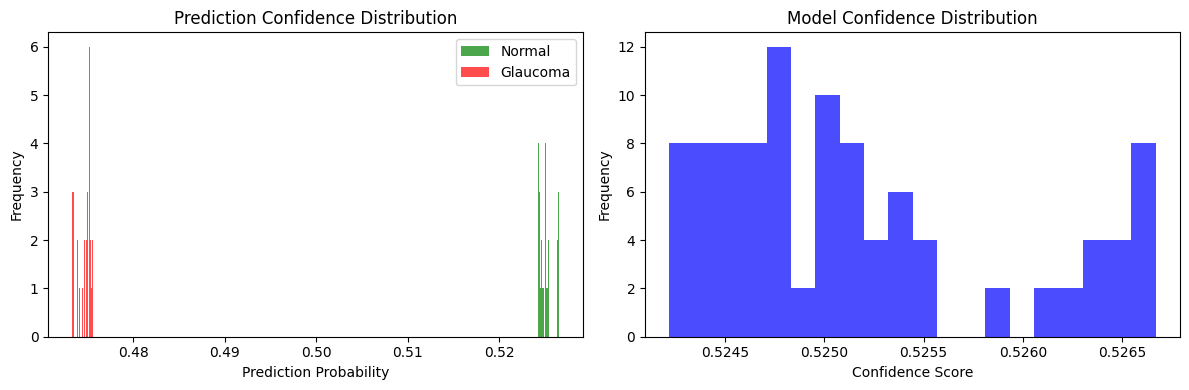

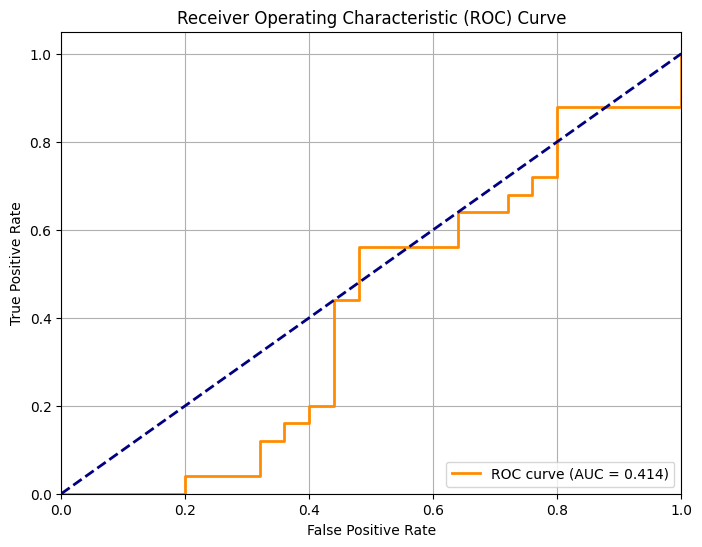

In [ ]:

print("\n" + "=" * 40)
print("STEP 5: EVALUATING MODEL")
print("=" * 40)

# Evaluate on test set
print("Evaluating model on test set...")
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_proba = y_pred[:, 1]  # Probability of positive class (glaucoma)

# Print classification report
print("\n CLASSIFICATION REPORT:")
print("=" * 40)
print(classification_report(y_true, y_pred_labels, target_names=labels_names))

# Calculate additional metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

# Create confusion matrix
print("Creating confusion matrix...")
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{STATIC_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Confusion matrix saved to static/confusion_matrix.png")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(f'{STATIC_DIR}/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(" ROC curve saved to static/roc_curve.png")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.savefig(f'{STATIC_DIR}/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Precision-Recall curve saved to static/precision_recall_curve.png")

# Calculate per-class metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Per-class metrics
precision_per_class = precision_score(y_true, y_pred_labels, average=None)
recall_per_class = recall_score(y_true, y_pred_labels, average=None)
f1_per_class = f1_score(y_true, y_pred_labels, average=None)

print("\n PER-CLASS METRICS:")
print("=" * 40)
for i, class_name in enumerate(labels_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")

# Overall metrics
print(f"\n OVERALL METRICS:")
print("=" * 40)
print(f"Accuracy: {np.mean(y_true == y_pred_labels):.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Macro Avg Precision: {np.mean(precision_per_class):.4f}")
print(f"Macro Avg Recall: {np.mean(recall_per_class):.4f}")
print(f"Macro Avg F1-Score: {np.mean(f1_per_class):.4f}")

# Save detailed evaluation results
evaluation_results = {
    'classification_report': classification_report(y_true, y_pred_labels, target_names=labels_names, output_dict=True),
    'confusion_matrix': cm.tolist(),
    'roc_auc': float(roc_auc),
    'average_precision': float(avg_precision),
    'per_class_metrics': {
        'precision': precision_per_class.tolist(),
        'recall': recall_per_class.tolist(),
        'f1_score': f1_per_class.tolist()
    },
    'overall_metrics': {
        'accuracy': float(np.mean(y_true == y_pred_labels)),
        'macro_avg_precision': float(np.mean(precision_per_class)),
        'macro_avg_recall': float(np.mean(recall_per_class)),
        'macro_avg_f1': float(np.mean(f1_per_class))
    }
}

with open(f'{STATIC_DIR}/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)
print(" Evaluation results saved to static/evaluation_results.json")

In [ ]:
print("\n" + "=" * 40)
print("STEP 6: PLOTTING TRAINING HISTORY")
print("=" * 40)

# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{STATIC_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("Training history saved to static/training_history.png")


5. FEATURE ANALYSIS AND INTERPRETABILITY
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Creating attention maps...


AttributeError: The layer sequential has never been called and thus has no defined input.

<Figure size 1500x1000 with 0 Axes>

In [ ]:
print("\n" + "=" * 40)
print("STEP 7: SAVING RESULTS")
print("=" * 40)

# Save training history
with open(HISTORY_PATH, 'w') as f:
    json.dump(history.history, f)

print("Training history saved to models/history.json")

# Print final metrics
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_auc = history.history['auc'][-1]
final_val_auc = history.history['val_auc'][-1]

print("\n FINAL RESULTS:")
print("=" * 40)
print(f"Final Training Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training AUC: {final_auc:.4f}")
print(f"Final Validation AUC: {final_val_auc:.4f}") 

In [ ]:
print("\n" + "=" * 60)
print(" TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 60)

print("\n FILES CREATED:")
print(f" Model: {MODEL_PATH}")
print(f"History: {HISTORY_PATH}")
print(f" Evaluation Results: {STATIC_DIR}/evaluation_results.json")
print(f" Dataset Summary: {STATIC_DIR}/dataset_summary.json")

print("\n VISUALIZATIONS CREATED:")
print(f" Class Distribution: {STATIC_DIR}/class_distribution.png")
print(f" Sample Images: {STATIC_DIR}/sample_images.png")
print(f" Pixel Analysis: {STATIC_DIR}/pixel_analysis.png")
print(f" Image Characteristics: {STATIC_DIR}/image_characteristics.png")
print(f" Confusion Matrix: {STATIC_DIR}/confusion_matrix.png")
print(f" ROC Curve: {STATIC_DIR}/roc_curve.png")
print(f" Precision-Recall Curve: {STATIC_DIR}/precision_recall_curve.png")
print(f" Training History: {STATIC_DIR}/training_history.png")

print("\n KEY METRICS:")
print(f"Final Training Accuracy: {final_accuracy:.4f}")
print(f" Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f" Final Training AUC: {final_auc:.4f}")
print(f" Final Validation AUC: {final_val_auc:.4f}")
print(f" Test ROC AUC: {roc_auc:.4f}")
print(f" Test Average Precision: {avg_precision:.4f}")

print("\n NEXT STEPS:")
print("1. Your model is ready for predictions!")
print("2. Run the Streamlit app: streamlit run UI/streamlit_app.py")
print("3. Or use the API: python src/app.py")
print("4. For predictions: python src/prediction.py")
print("5. View all visualizations in the static/ directory")

print("\n" + "=" * 60) 